## Lab 6, Group 2
### Names: Hailey DeMark, Deborah Park, Karis Park
### Student IDs: 48869449, 48878679, 48563429

Dataset: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset/data

In [20]:
import os 
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [21]:
np.random.seed(0)
tf.random.set_seed(2)

# define dataset directory
dataset_path = 'Brain Tumor Data Set' 

# collect all image paths and labels
image_paths = []
image_labels = []

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))
            image_labels.append(os.path.basename(root)) 

print(f"Found {len(image_paths)} images.")

# load and preprocess images in grayscale (size 64x64)
image_data = []
for file in image_paths:
    try:
        image = Image.open(file).convert('L')         # convert to grayscale
        image = image.resize((64, 64))                # resize to fixed size
        image_array = np.array(image)                 # convert to NumPy array
        image_data.append(image_array)
    except Exception as e:
        print(f"Error loading {file}: {e}")

# convert list to NumPy array and normalize pixel values
X = np.array(image_data, dtype='float32') / 255.0
X = X.reshape(-1, 64, 64, 1)  # Add grayscale channel dimension

print("X shape:", X.shape)

# encode text labels to binary integers (e.g., yes = 1, no = 0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(image_labels)
print("Encoded labels:", np.unique(y))

Found 4514 images.
X shape: (4514, 64, 64, 1)
Encoded labels: [0 1]


### Preparation (3 points total)  
* [1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

    * We will use recall as our evaluation metric. Recall is the best metric to evaluate our algorithm's performance since our dataset show MRI scans of potential brain tumors. In this case, a false negative (incorrectly identifying that a tumor is not present) can be extremely serious. Failing to detect a brain tumor can lead to missed or delayed treatment, which would lead to more severe conditions or death. While a false positive may cause unnecessary procedures, more testing, and emotional distress, it is significantly less harmful than overlooking a real tumor. Using recall ensures that the model is optimized to catch as many true tumor cases as possible, even at the expense of preidicting more false positives cases. In the context of medical diagnostics, especially for conditions as serious as brain cancer, it is better to err on the side of caution rather than risk missing anything.  

* [1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

    *  (I asked AI to verify if we could do a stratified 80/20 split for this lab like our last lab since I wasn't sure how big the dataset should be to be considered big enough to use this split...AI said a stratified 80/20 split is best with another stratified 80/20 split on the training data. I explain more in my explantation, but feel free to change!!)
    

    * We will use a stratified 80/20 split to separate the data into training and test sets, ensuring that the test set remains unseen throughout training and tuning. From the 80% training set, we will then apply another stratified 80/20 split to create a separate validation set so that 64% of the data is traiing data, 16% is validation data, and 20% is test data. This two-step stratified approach is ideal because it ensures that all subsets maintain a consistent proportion of tumor and non-tumor images and it ensures balanced performance metrics. Our dataset has about 55% cancerous images and 44% non-cancerous images, so by using a stratified split, this ensures that each split will reflect the original distribution of the two cases of images. The separate validation set will allow for hyperparameter tuning and modifying the model without touching the test set, and also helps to avoid overfitting to test metrics. In our case, K-fold cross-validation is computationally expensive due to training CNNs and our large dataset. 

In [22]:
# 1. First split: training vs test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Second split: training vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

### Modeling (6 points total)
* [1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You should make use of Keras augmentation layers, like in the class examples.

    * (add in explaination about Data Expansion in Keras)

In [23]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, RandomContrast
from tensorflow.keras.layers import RandomContrast, RandomTranslation, RandomZoom
from tensorflow.keras.layers import RandomRotation, RandomFlip
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
keras.__version__

'3.9.0'

In [24]:
# Data Augmentation Layer
data_augmentation = Sequential([
    RandomFlip("horizontal"),         # Reflect common real-world scan orientation variance
    RandomRotation(0.05),             # Small tilts from patient positioning
    RandomZoom(0.1),                  # Variance in zoom/focus during imaging
    RandomTranslation(0.1, 0.1),      # Simulate slight patient movement
    RandomContrast(0.1)               # Reflect scanner lighting/contrast differences
], name="data_augmentation")

# CNN Model with augmentation included
model = Sequential()
model.add(data_augmentation)  # Augmentation applied during training only
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary output for tumor classification

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['Recall', 'Precision', 'accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    shuffle=True,
    verbose=1
)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - Precision: 0.5434 - Recall: 0.4732 - accuracy: 0.5563 - loss: 0.6873 - val_Precision: 0.6346 - val_Recall: 0.5719 - val_accuracy: 0.6501 - val_loss: 0.6195
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - Precision: 0.6330 - Recall: 0.5944 - accuracy: 0.6403 - loss: 0.6419 - val_Precision: 0.6505 - val_Recall: 0.7246 - val_accuracy: 0.6929 - val_loss: 0.5471
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - Precision: 0.7059 - Recall: 0.6505 - accuracy: 0.7040 - loss: 0.5715 - val_Precision: 0.7930 - val_Recall: 0.6766 - val_accuracy: 0.7690 - val_loss: 0.4795
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - Precision: 0.7554 - Recall: 0.6804 - accuracy: 0.7422 - loss: 0.5188 - val_Precision: 0.8202 - val_Recall: 0.6557 - val_accuracy: 0.7746 - val_loss: 0.4598
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - Precision: 0.7890 - Recall: 0.6919 - accuracy: 0.7633 - loss: 0.4843 - val_Precision: 0.7857 - val_Recall: 0.7575 - val_

* [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures and investigate changing one or more parameters of each architecture such as the number of filters. This means, at a  minimum, you will train a total of four models (2 different architectures, with 2 parameters changed in each architecture). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

* [1.5 points] Visualize the final results of all the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 


Training Simple CNN (16 filters)...
Epoch 1/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - Precision: 0.5410 - Recall: 0.5077 - accuracy: 0.5535 - loss: 0.6755 - val_Precision: 0.6903 - val_Recall: 0.7275 - val_accuracy: 0.7234 - val_loss: 0.5402
Epoch 2/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - Precision: 0.6911 - Recall: 0.6064 - accuracy: 0.6819 - loss: 0.5983 - val_Precision: 0.7039 - val_Recall: 0.8114 - val_accuracy: 0.7552 - val_loss: 0.5225
Epoch 3/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - Precision: 0.7341 - Recall: 0.6358 - accuracy: 0.7164 - loss: 0.5698 - val_Precision: 0.6736 - val_Recall: 0.8713 - val_accuracy: 0.7455 - val_loss: 0.5191
Epoch 4/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - Precision: 0.7226 - Recall: 0.6418 - accuracy: 0.7120 - loss: 0.5497 - val_Precision: 0.7283 - val_Recall: 0.8024 - val_accuracy: 0.7704 - val_loss: 0.4746
Epoch 5/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - Precision: 0.7491 - Recall: 0.6841 - accuracy: 0.7394 - loss: 0.5188 - val_Prec

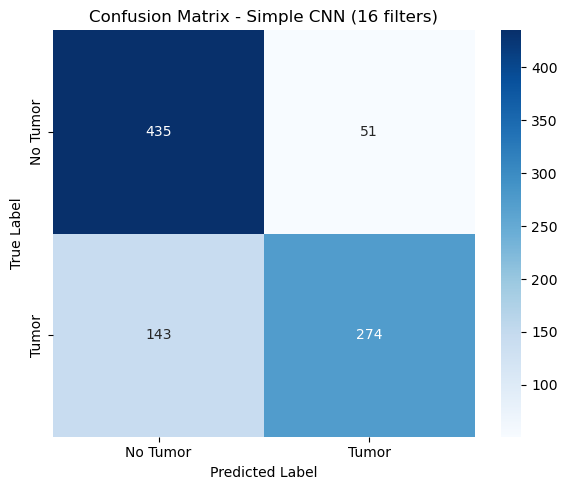


Training Simple CNN (32 filters)...
Epoch 1/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - Precision: 0.5804 - Recall: 0.5142 - accuracy: 0.5881 - loss: 0.6755 - val_Precision: 0.7563 - val_Recall: 0.5389 - val_accuracy: 0.7068 - val_loss: 0.5776
Epoch 2/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - Precision: 0.6767 - Recall: 0.5875 - accuracy: 0.6687 - loss: 0.6078 - val_Precision: 0.7151 - val_Recall: 0.7515 - val_accuracy: 0.7469 - val_loss: 0.5073
Epoch 3/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - Precision: 0.7218 - Recall: 0.6252 - accuracy: 0.7052 - loss: 0.5781 - val_Precision: 0.7339 - val_Recall: 0.7515 - val_accuracy: 0.7593 - val_loss: 0.4936
Epoch 4/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - Precision: 0.7417 - Recall: 0.6428 - accuracy: 0.7229 - loss: 0.5456 - val_Precision: 0.7678 - val_Recall: 0.7425 - val_accuracy: 0.7773 - val_loss: 0.4610
Epoch 5/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - Precision: 0.7511 - Recall: 0.6668 - accuracy: 0.7346 - loss: 0.5228 - val_Prec

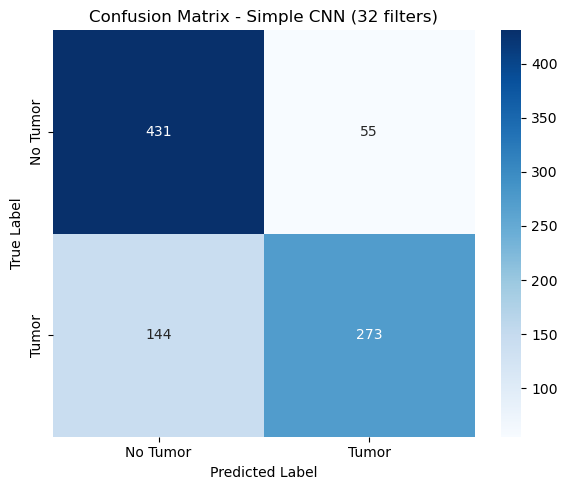


Training Deep CNN (16 filters)...
Epoch 1/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - Precision: 0.5340 - Recall: 0.4481 - accuracy: 0.5440 - loss: 0.6832 - val_Precision: 0.7834 - val_Recall: 0.5090 - val_accuracy: 0.7082 - val_loss: 0.5996
Epoch 2/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - Precision: 0.6571 - Recall: 0.5890 - accuracy: 0.6549 - loss: 0.6296 - val_Precision: 0.6217 - val_Recall: 0.7874 - val_accuracy: 0.6805 - val_loss: 0.5741
Epoch 3/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - Precision: 0.7137 - Recall: 0.6273 - accuracy: 0.7017 - loss: 0.5800 - val_Precision: 0.6704 - val_Recall: 0.7126 - val_accuracy: 0.7054 - val_loss: 0.5281
Epoch 4/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - Precision: 0.7194 - Recall: 0.6253 - accuracy: 0.7041 - loss: 0.5580 - val_Precision: 0.6550 - val_Recall: 0.8413 - val_accuracy: 0.7220 - val_loss: 0.5009
Epoch 5/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - Precision: 0.7344 - Recall: 0.6900 - accuracy: 0.7325 - loss: 0.5136 - val_Preci

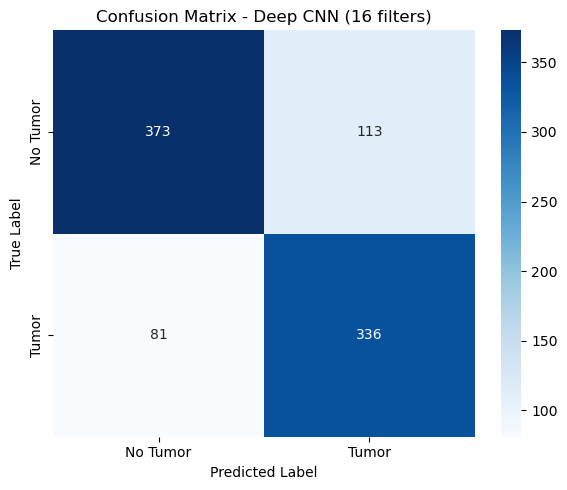


Training Deep CNN (32 filters)...
Epoch 1/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - Precision: 0.5096 - Recall: 0.4261 - accuracy: 0.5288 - loss: 0.6868 - val_Precision: 0.7692 - val_Recall: 0.4192 - val_accuracy: 0.6736 - val_loss: 0.6703
Epoch 2/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 272ms/step - Precision: 0.6445 - Recall: 0.5527 - accuracy: 0.6375 - loss: 0.6504 - val_Precision: 0.7127 - val_Recall: 0.7575 - val_accuracy: 0.7469 - val_loss: 0.5158
Epoch 3/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - Precision: 0.7481 - Recall: 0.6396 - accuracy: 0.7254 - loss: 0.5763 - val_Precision: 0.6398 - val_Recall: 0.8084 - val_accuracy: 0.7012 - val_loss: 0.5754
Epoch 4/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - Precision: 0.7658 - Recall: 0.7156 - accuracy: 0.7598 - loss: 0.5059 - val_Precision: 0.6395 - val_Recall: 0.8234 - val_accuracy: 0.7040 - val_loss: 0.5672
Epoch 5/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step - Precision: 0.7592 - Recall: 0.7130 - accuracy: 0.7557 - loss: 0.4780 - 

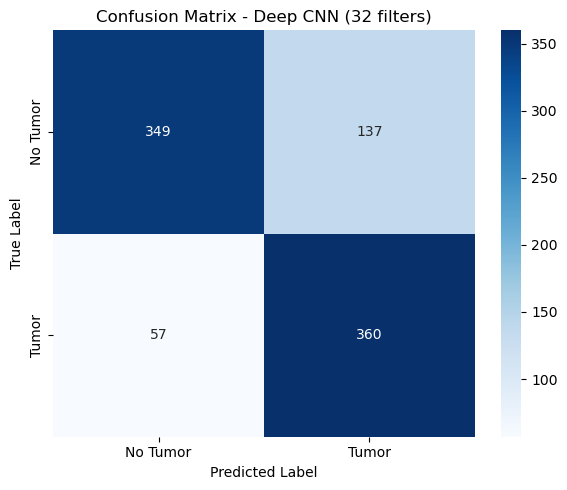

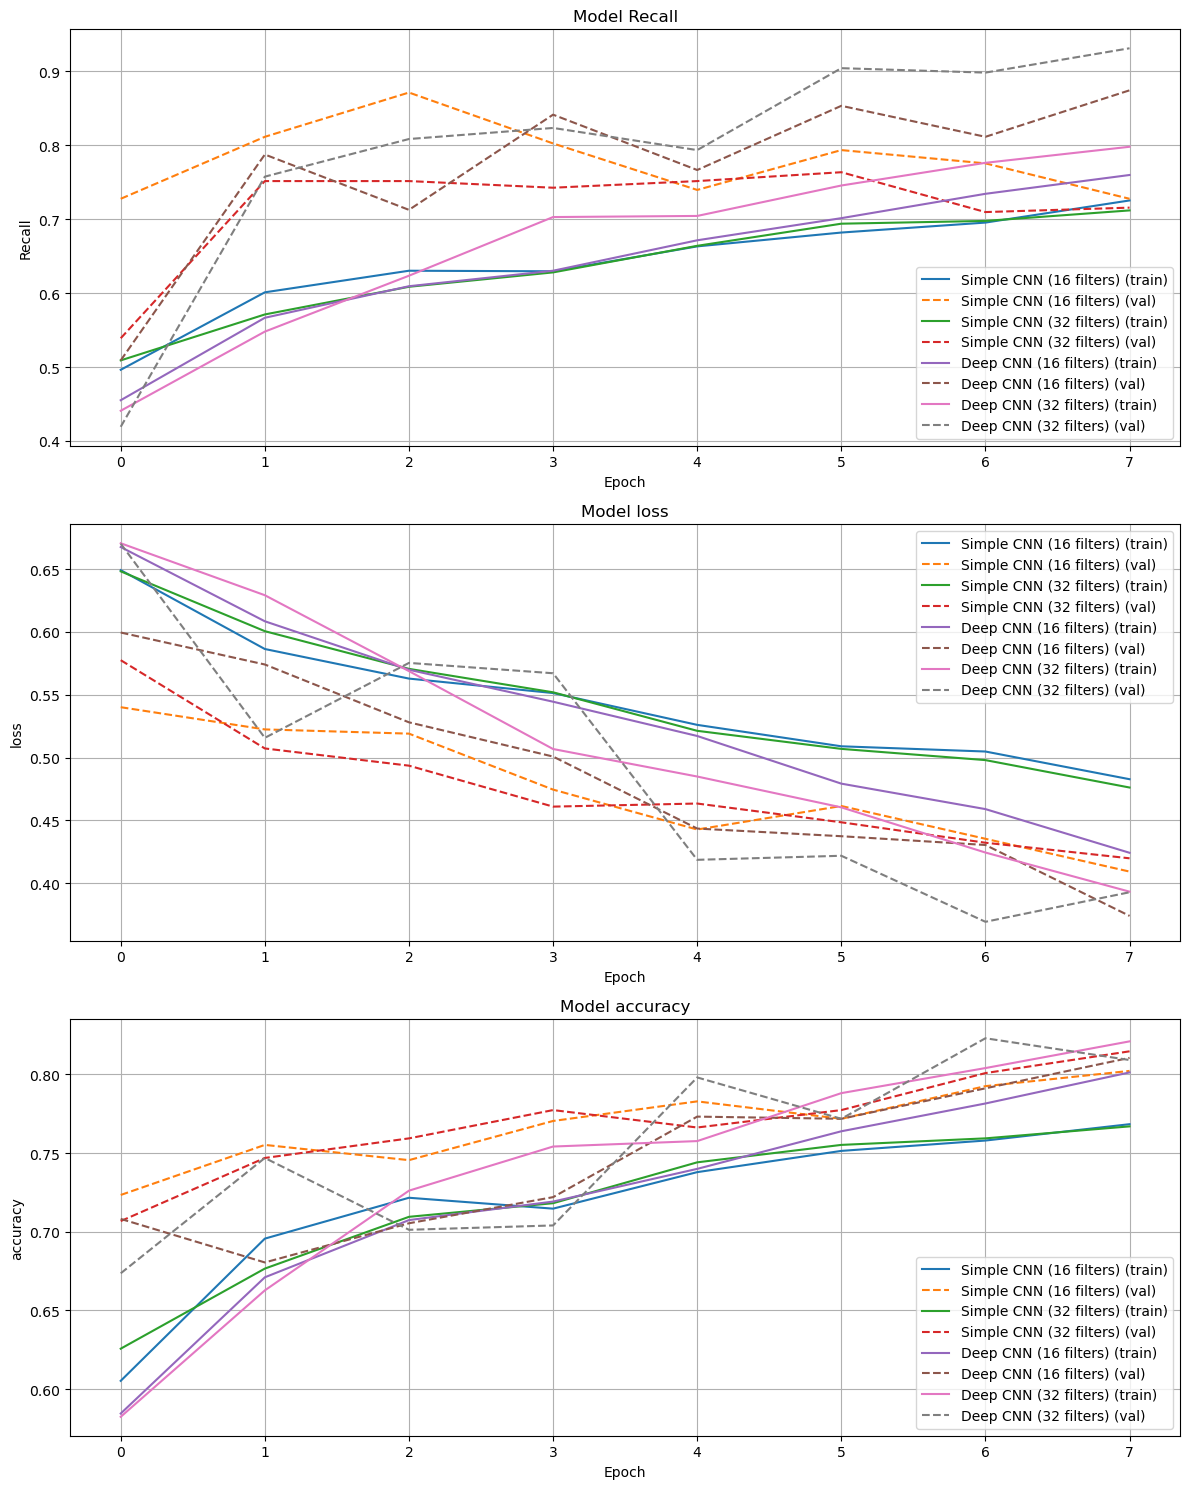

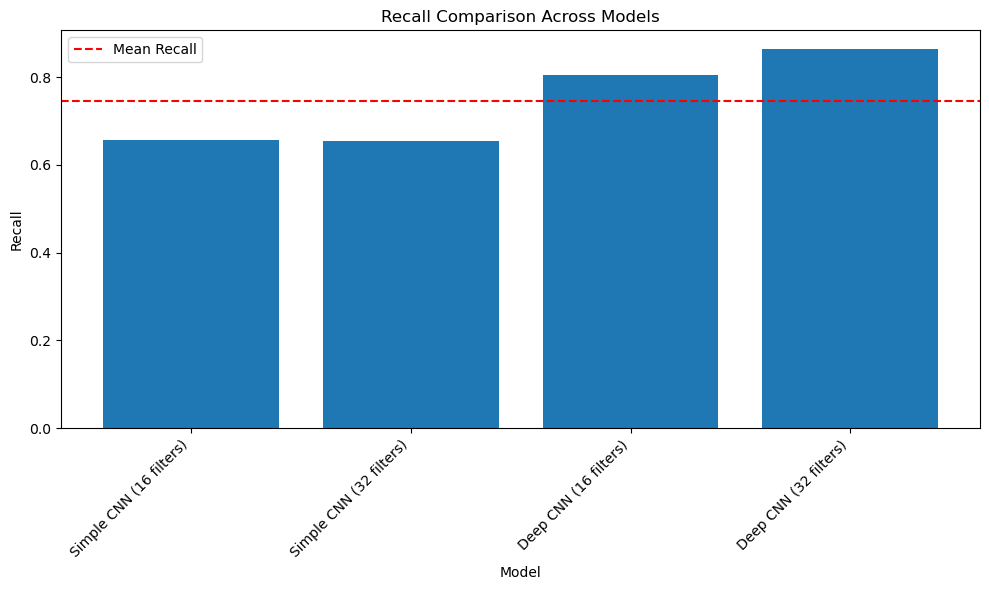

Best model based on recall: Deep CNN (32 filters)
Best recall achieved: 0.8633


In [25]:
# Model names for reference
model_names = [
    "Simple CNN (16 filters)",
    "Simple CNN (32 filters)",
    "Deep CNN (16 filters)",
    "Deep CNN (32 filters)"
]

# Define function to create simple CNN architecture
def create_simple_cnn(filters=16):
    model = Sequential([
        # Data augmentation layer (already defined earlier)
        data_augmentation,
        
        # Simple CNN structure
        Conv2D(filters, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D((2, 2)),
        
        Conv2D(filters*2, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Define function to create deeper CNN architecture
def create_deep_cnn(filters=16):
    model = Sequential([
        # Data augmentation layer (already defined earlier)
        data_augmentation,
        
        # Deep CNN with more layers
        Conv2D(filters, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
        Conv2D(filters, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(filters*2, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(filters*4, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create models
models = [
    create_simple_cnn(filters=16),
    create_simple_cnn(filters=32),
    create_deep_cnn(filters=16),
    create_deep_cnn(filters=32)
]

# Train models
histories = []

for i, (model, name) in enumerate(zip(models, model_names)):
    print(f"\nTraining {name}...")
    
    # Compile 
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['Recall', 'Precision', 'accuracy']
    )
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=8,  # Reduced from 20+ to 8
        batch_size=32,
        verbose=1
    )
    
    histories.append(history)
    
    # Evaluate
    test_loss, test_recall, test_precision, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Get predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    # Print 
    print(f"\nResults for {name}:")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Tumor', 'Tumor'],
                yticklabels=['No Tumor', 'Tumor'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Visualize
metrics = ['Recall', 'loss', 'accuracy']
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 15))

for i, metric in enumerate(metrics):
    ax = axes[i]
    for j, history in enumerate(histories):
        ax.plot(history.history[metric], label=f'{model_names[j]} (train)')
        ax.plot(history.history[f'val_{metric}'], linestyle='--', 
                label=f'{model_names[j]} (val)')
    
    ax.set_title(f'Model {metric}')
    ax.set_ylabel(metric)
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    ax.grid(True)

plt.tight_layout()
plt.show()

# Compare model 
test_recalls = []
for model, name in zip(models, model_names):
    _, recall, _, _ = model.evaluate(X_test, y_test, verbose=0)
    test_recalls.append(recall)

plt.figure(figsize=(10, 6))
plt.bar(model_names, test_recalls)
plt.title('Recall Comparison Across Models')
plt.ylabel('Recall')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.axhline(y=np.mean(test_recalls), color='r', linestyle='--', label='Mean Recall')
plt.legend()
plt.show()

# Determine best model
best_model_index = np.argmax(test_recalls)
print(f"Best model based on recall: {model_names[best_model_index]}")
print(f"Best recall achieved: {test_recalls[best_model_index]:.4f}")

* [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

Training MLP model...
Epoch 1/8


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Precision: 0.5078 - Recall: 0.5434 - accuracy: 0.5313 - loss: 0.7876 - val_Precision: 0.7833 - val_Recall: 0.4760 - val_accuracy: 0.6971 - val_loss: 0.6064
Epoch 2/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Precision: 0.6217 - Recall: 0.5696 - accuracy: 0.6276 - loss: 0.6320 - val_Precision: 0.8200 - val_Recall: 0.6138 - val_accuracy: 0.7593 - val_loss: 0.5276
Epoch 3/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7361 - Recall: 0.6014 - accuracy: 0.7066 - loss: 0.5757 - val_Precision: 0.8876 - val_Recall: 0.6856 - val_accuracy: 0.8147 - val_loss: 0.4828
Epoch 4/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.8007 - Recall: 0.6529 - accuracy: 0.7574 - loss: 0.5172 - val_Precision: 0.8516 - val_Recall: 0.7216 - val_accuracy: 0.8133 - val_loss: 0.4465
Epoch 5/8
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Precision: 0.8405 - Recall: 0.6396 - accuracy: 0.7703 - loss: 0.4901 - val_Precision: 0.8089 - val_Recall: 0.7605 - val_accuracy: 0

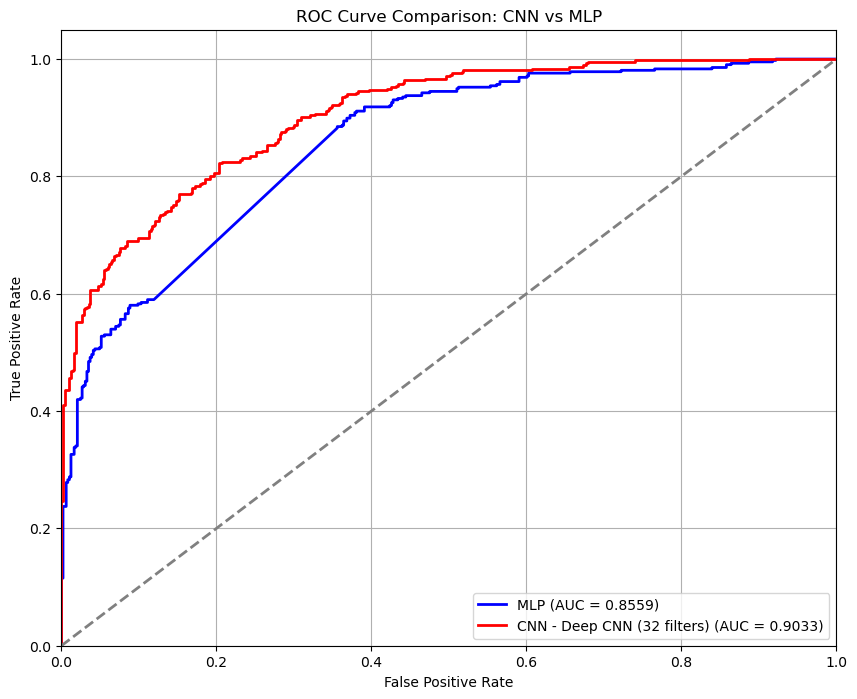


Statistical Comparison of ROC AUC Values:
MLP AUC: 0.8559 [95% CI: 0.8328-0.8772]
CNN AUC: 0.9033 [95% CI: 0.8844-0.9225]
AUC Difference: 0.0474
P-value: 0.0000
The CNN model significantly outperforms the MLP model.

Recall Comparison:
MLP Recall: 0.5060
CNN Recall: 0.8633


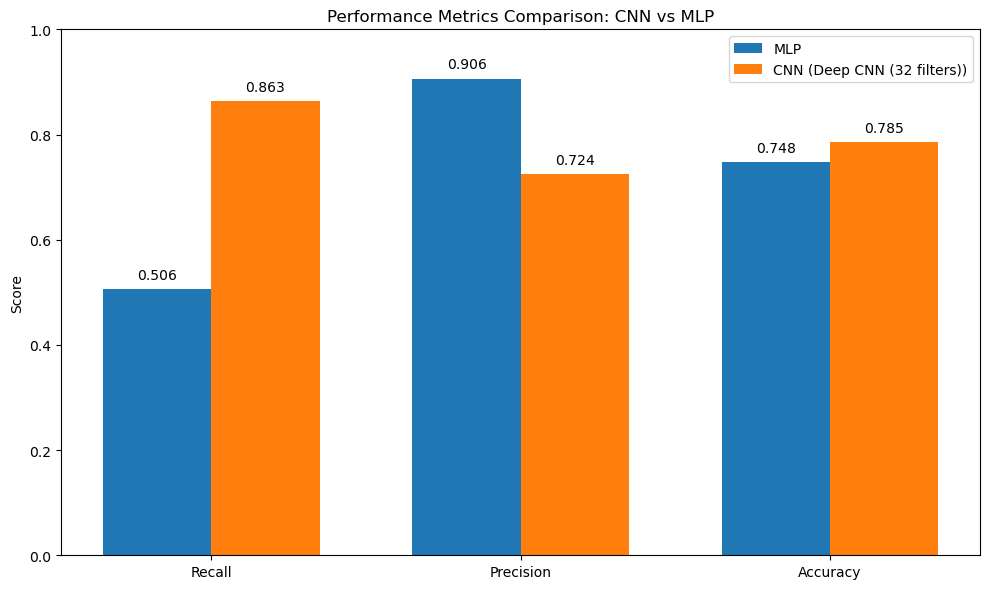

In [26]:
# Create a simple MLP model
def create_mlp():
    # Flatten the input images first (64x64x1 -> 4096)
    model = Sequential([
        Flatten(input_shape=(64, 64, 1)),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create and train the MLP model
mlp_model = create_mlp()
mlp_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall', 'Precision', 'accuracy']
)

# Choose one of our CNN models for comparison (using the best one from previous section)
best_cnn_model = models[best_model_index]
best_cnn_name = model_names[best_model_index]

print("Training MLP model...")
mlp_history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=8,
    batch_size=32,
    verbose=1
)

# Get predictions for ROC curves
mlp_pred_prob = mlp_model.predict(X_test)
cnn_pred_prob = best_cnn_model.predict(X_test)

# Calculate ROC curve and AUC for both models
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_pred_prob)
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_pred_prob)

mlp_auc = auc(mlp_fpr, mlp_tpr)
cnn_auc = auc(cnn_fpr, cnn_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(mlp_fpr, mlp_tpr, color='blue', lw=2, label=f'MLP (AUC = {mlp_auc:.4f})')
plt.plot(cnn_fpr, cnn_tpr, color='red', lw=2, label=f'CNN - {best_cnn_name} (AUC = {cnn_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: CNN vs MLP')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Statistical comparison using bootstrapping for AUC values
def bootstrap_auc(y_true, y_pred, n_bootstraps=1000):
    auc_values = []
    n_samples = len(y_true)
    
    for i in range(n_bootstraps):
        # Bootstrap sampling with replacement
        indices = np.random.choice(range(n_samples), n_samples, replace=True)
        y_true_bootstrap = y_true[indices]
        y_pred_bootstrap = y_pred[indices]
        
        # Calculate AUC for the bootstrap sample
        try:
            auc_value = roc_auc_score(y_true_bootstrap, y_pred_bootstrap)
            auc_values.append(auc_value)
        except:
            # Skip if the bootstrap sample has only one class
            continue
    
    return np.array(auc_values)

# Perform bootstrapping for both models
mlp_auc_bootstrap = bootstrap_auc(y_test, mlp_pred_prob.flatten(), n_bootstraps=1000)
cnn_auc_bootstrap = bootstrap_auc(y_test, cnn_pred_prob.flatten(), n_bootstraps=1000)

# Calculate 95% confidence intervals
mlp_auc_ci = np.percentile(mlp_auc_bootstrap, [2.5, 97.5])
cnn_auc_ci = np.percentile(cnn_auc_bootstrap, [2.5, 97.5])

# Calculate p-value for the difference
# Using method described in DeLong et al. would be ideal, but for simplicity:
# we'll use a paired t-test on the bootstrapped AUC values
t_stat, p_value = stats.ttest_ind(cnn_auc_bootstrap, mlp_auc_bootstrap)

# Display statistical comparison
print("\nStatistical Comparison of ROC AUC Values:")
print(f"MLP AUC: {mlp_auc:.4f} [95% CI: {mlp_auc_ci[0]:.4f}-{mlp_auc_ci[1]:.4f}]")
print(f"CNN AUC: {cnn_auc:.4f} [95% CI: {cnn_auc_ci[0]:.4f}-{cnn_auc_ci[1]:.4f}]")
print(f"AUC Difference: {cnn_auc - mlp_auc:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    if cnn_auc > mlp_auc:
        print("The CNN model significantly outperforms the MLP model.")
    else:
        print("The MLP model significantly outperforms the CNN model.")
else:
    print("There is no statistically significant difference between the models.")

# Also compare recall, which was our primary metric
mlp_results = mlp_model.evaluate(X_test, y_test, verbose=0)
cnn_results = best_cnn_model.evaluate(X_test, y_test, verbose=0)

print("\nRecall Comparison:")
print(f"MLP Recall: {mlp_results[1]:.4f}")
print(f"CNN Recall: {cnn_results[1]:.4f}")

# Visualize metric comparison
metrics = ['Recall', 'Precision', 'Accuracy']
mlp_metrics = [mlp_results[1], mlp_results[2], mlp_results[3]]
cnn_metrics = [cnn_results[1], cnn_results[2], cnn_results[3]]

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, mlp_metrics, width, label='MLP')
plt.bar(x + width/2, cnn_metrics, width, label=f'CNN ({best_cnn_name})')

plt.ylabel('Score')
plt.title('Performance Metrics Comparison: CNN vs MLP')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

for i, v in enumerate(mlp_metrics):
    plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center')
    
for i, v in enumerate(cnn_metrics):
    plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

### Exceptional Work (1 points total)
You have free reign to provide additional analyses. 
One idea (required for 7000 level students): Use transfer learning with pre-trained weights for your initial layers of your CNN. Compare the performance when using transfer learning to your best model from above in terms of classification performance. 